# Food recognition

**Computer Vision Classification CNN TinyVGG on Food101 extract dataset**

## 0. Data preparation

The entire dataset was downloaded from: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

Then, it was simplified with the below script, zipped and uploaded to GitHub.


```
import os
import random
import shutil

def split_images(source_folder, food_types, num_images, train_ratio):
    for food_type in food_types:
        source_path = os.path.join(source_folder, food_type)
        images = os.listdir(source_path)
        selected_images = random.sample(images, num_images)
        
        train_size = int(train_ratio * num_images)
        train_images = selected_images[:train_size]
        test_images = selected_images[train_size:]
        
        # Make new folders
        train_path = os.path.join("train", food_type)
        test_path = os.path.join("test", food_type)
        os.makedirs(train_path, exist_ok=True)
        os.makedirs(test_path, exist_ok=True)
        
        # Copy images
        for image in train_images:
            source = os.path.join(source_path, image)
            destination = os.path.join(train_path, image)
            shutil.copyfile(source, destination)
        
        for image in test_images:
            source = os.path.join(source_path, image)
            destination = os.path.join(test_path, image)
            shutil.copyfile(source, destination)

# Extract data
source_folder = "images"
food_types = ["paella", "hamburger", "cheesecake", "gnocchi", "guacamole"]
num_images = 200
train_ratio = 0.8

split_images(source_folder, food_types, num_images, train_ratio)

```

Data is stored in the following format:

```
train/
    class01/
        image01.jpeg
        image02.jpeg
        ...
    class02/
        image04.jpeg
        image05.jpeg
        ...
    ...
test/
    class01/
        image101.jpeg
        image102.jpeg
        ...
    class02/
        image104.jpeg
        image105.jpeg
        ...
    .../
```

In [1]:
import torch
from torch import nn

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

Download data from GitHub

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "food101_extract"

# Create data folder if doesn't exist
if image_path.is_dir():
  print(f"{image_path} directory already exists")
else:
  image_path.mkdir(parents=True, exist_ok=True)
  print(f"{image_path} directory created")

# Download food101_extract data
with open(data_path / "food101_extract.zip", "wb") as f:
  request = requests.get("https://github.com/slawomirwojtas/ML-Projects/raw/main/food101_extract.zip")
  print("Downloading food101_extract data...")
  f.write(request.content)

# Unzip food101_extract data
with zipfile.ZipFile(data_path / "food101_extract.zip", "r") as zip_ref:
  print("Unzipping food101_extract data...")
  zip_ref.extractall(image_path)
  print("Done")

data/food101_extract directory created
Unzipping food101_extract data...
Done


## 2. Data exploration

In [3]:
import os
def walk_trhough_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_trhough_dir(image_path)

There are 2 directories and 0 images in 'data/food101_extract'.
There are 5 directories and 0 images in 'data/food101_extract/test'.
There are 0 directories and 40 images in 'data/food101_extract/test/cheesecake'.
There are 0 directories and 40 images in 'data/food101_extract/test/hamburger'.
There are 0 directories and 40 images in 'data/food101_extract/test/paella'.
There are 0 directories and 40 images in 'data/food101_extract/test/guacamole'.
There are 0 directories and 40 images in 'data/food101_extract/test/gnocchi'.
There are 5 directories and 0 images in 'data/food101_extract/train'.
There are 0 directories and 160 images in 'data/food101_extract/train/cheesecake'.
There are 0 directories and 160 images in 'data/food101_extract/train/hamburger'.
There are 0 directories and 160 images in 'data/food101_extract/train/paella'.
There are 0 directories and 160 images in 'data/food101_extract/train/guacamole'.
There are 0 directories and 160 images in 'data/food101_extract/train/gnocc

In [4]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/food101_extract/train'),
 PosixPath('data/food101_extract/test'))

### 2.1 Visualizing a random image

Random image path: data/food101_extract/train/cheesecake/2936529.jpg
Image class: cheesecake
Image height: 512
Image width: 512


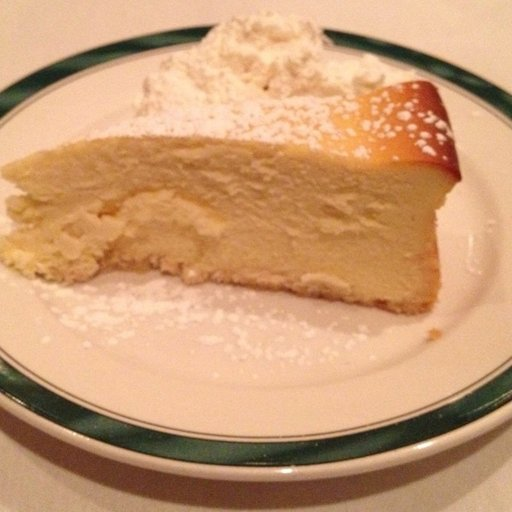

In [5]:
import random
from PIL import Image

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Pick random image path
random_image_path = random.choice(image_path_list)

# Get image class from path name
image_class = random_image_path.parent.stem

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

(-0.5, 511.5, 511.5, -0.5)

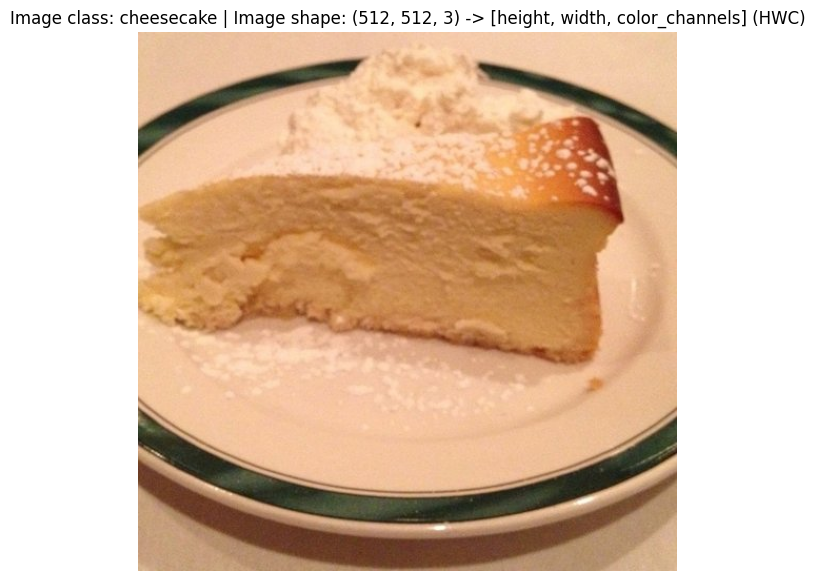

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels] (HWC)")
plt.axis(False)

## 3. Data transforming

In [7]:
from torchvision import transforms

# Write a transform for an image
image_transform_simple = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])

In [8]:
image_transform_simple(img).shape, image_transform_simple(img).dtype

(torch.Size([3, 224, 224]), torch.float32)

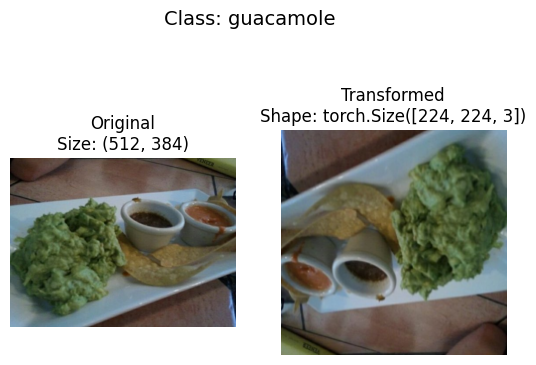

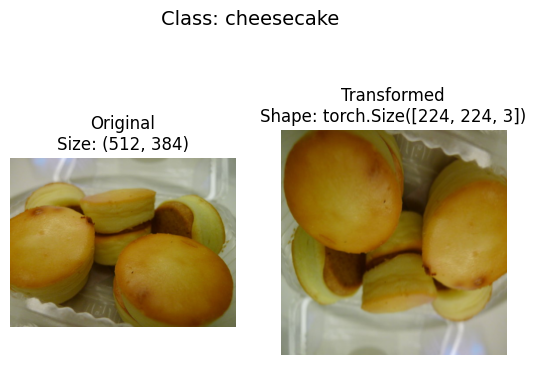

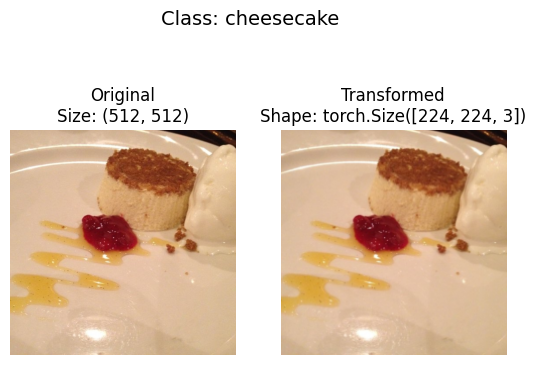

In [9]:
def plot_transformed_images(image_paths: list,
                            transform,
                            n=3,
                            seed=None):
  """
  Select random images from a path of images and transforms them,
  then plots the original and the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # change shape for matplotlib (CHW) -> (HWC)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=14)

plot_transformed_images(image_paths=image_path_list,
                        transform=image_transform_simple)

## 4. Preparation of Datasets and DataLoaders

In [10]:
from torchvision import datasets

# Create datasets from training and testing data
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=image_transform_simple,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=image_transform_simple,
                                 target_transform=None)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 800
     Root location: data/food101_extract/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 200
     Root location: data/food101_extract/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ToTensor()
            ))

In [11]:
# Get class names as list
class_names = train_data.classes
class_names

['cheesecake', 'gnocchi', 'guacamole', 'hamburger', 'paella']

In [12]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'cheesecake': 0, 'gnocchi': 1, 'guacamole': 2, 'hamburger': 3, 'paella': 4}

In [13]:
# Index on the train_data Dataset to get a single random image and label
random_idx = random.randrange(0, len(train_data))
img, label = train_data[random_idx][0], train_data[random_idx][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label as text: {class_names[label]}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.8000, 0.7843, 0.7882,  ..., 0.8196, 0.8196, 0.8157],
         [0.8039, 0.7961, 0.7922,  ..., 0.8078, 0.8157, 0.8078],
         [0.8039, 0.8000, 0.7961,  ..., 0.7922, 0.7961, 0.7961],
         ...,
         [0.6157, 0.6157, 0.6235,  ..., 0.7098, 0.7020, 0.7020],
         [0.6157, 0.6196, 0.6196,  ..., 0.7098, 0.6980, 0.7020],
         [0.6078, 0.6196, 0.6196,  ..., 0.7020, 0.6941, 0.6941]],

        [[0.7647, 0.7569, 0.7686,  ..., 0.7020, 0.7020, 0.6980],
         [0.7647, 0.7647, 0.7765,  ..., 0.7059, 0.7137, 0.7098],
         [0.7725, 0.7765, 0.7843,  ..., 0.7098, 0.7216, 0.7216],
         ...,
         [0.5647, 0.5647, 0.5765,  ..., 0.5294, 0.5255, 0.5294],
         [0.5608, 0.5686, 0.5686,  ..., 0.5333, 0.5255, 0.5294],
         [0.5529, 0.5647, 0.5647,  ..., 0.5294, 0.5216, 0.5294]],

        [[0.7569, 0.7490, 0.7647,  ..., 0.6745, 0.6784, 0.6784],
         [0.7647, 0.7647, 0.7725,  ..., 0.6667, 0.6824, 0.6784],
         [0.7765, 0.7725, 0.7843,  ..., 0.6

Text(0.5, 1.0, 'gnocchi')

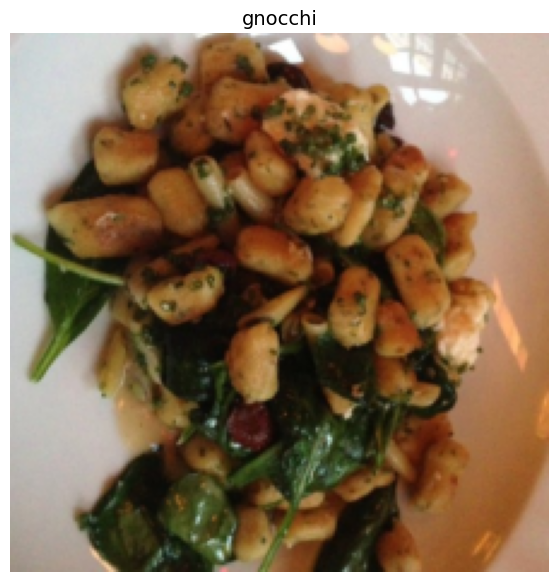

In [14]:
# Plot the image
img_permute = img.permute(1, 2, 0)
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

In [15]:
from torch.utils.data import DataLoader

# Turn train and test datasets into DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() # as many as possible

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, len(train_dataloader), test_dataloader, len(test_dataloader)

(<torch.utils.data.dataloader.DataLoader at 0x799dcda65d50>,
 25,
 7)

In [16]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}, -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]), -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


## 5. Model training

TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

### 5.1 Create TinyVGG model class

In [17]:
# Create TinyVGG model
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*53*53,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x

In [18]:
# Instantiate the model and put on target device
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=28090, out_features=5, bias=True)
  )
)

In [19]:
# Try a forward pass on a single image batch
image_batch, label_batch = next(iter(train_dataloader))
print(image_batch.shape, label_batch.shape)
model_0(image_batch.to(device))

torch.Size([32, 3, 224, 224]) torch.Size([32])


tensor([[ 0.0047,  0.0192, -0.0034, -0.0114,  0.0450],
        [ 0.0031,  0.0220, -0.0023, -0.0114,  0.0471],
        [ 0.0056,  0.0216, -0.0031, -0.0109,  0.0435],
        [ 0.0050,  0.0196, -0.0020, -0.0102,  0.0442],
        [ 0.0046,  0.0202, -0.0040, -0.0099,  0.0451],
        [ 0.0024,  0.0187, -0.0044, -0.0106,  0.0441],
        [ 0.0040,  0.0193, -0.0031, -0.0103,  0.0443],
        [ 0.0041,  0.0196, -0.0034, -0.0113,  0.0437],
        [ 0.0036,  0.0179, -0.0029, -0.0112,  0.0437],
        [ 0.0053,  0.0212, -0.0058, -0.0085,  0.0462],
        [ 0.0038,  0.0200, -0.0037, -0.0112,  0.0452],
        [ 0.0045,  0.0205, -0.0035, -0.0116,  0.0444],
        [ 0.0037,  0.0197, -0.0041, -0.0109,  0.0437],
        [ 0.0042,  0.0222, -0.0045, -0.0091,  0.0439],
        [ 0.0044,  0.0209, -0.0038, -0.0116,  0.0441],
        [ 0.0038,  0.0203, -0.0044, -0.0099,  0.0449],
        [ 0.0040,  0.0211, -0.0031, -0.0118,  0.0450],
        [ 0.0061,  0.0247, -0.0023, -0.0116,  0.0494],
        [ 

### 5.2 Use torchinfo to investigate the shapes sequence

In [20]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[8, 3, 224, 224])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [8, 5]                    --
├─Sequential: 1-1                        [8, 10, 110, 110]         --
│    └─Conv2d: 2-1                       [8, 10, 222, 222]         280
│    └─ReLU: 2-2                         [8, 10, 222, 222]         --
│    └─Conv2d: 2-3                       [8, 10, 220, 220]         910
│    └─ReLU: 2-4                         [8, 10, 220, 220]         --
│    └─MaxPool2d: 2-5                    [8, 10, 110, 110]         --
├─Sequential: 1-2                        [8, 10, 53, 53]           --
│    └─Conv2d: 2-6                       [8, 10, 108, 108]         910
│    └─ReLU: 2-7                         [8, 10, 108, 108]         --
│    └─Conv2d: 2-8                       [8, 10, 106, 106]         910
│    └─ReLU: 2-9                         [8, 10, 106, 106]         --
│    └─MaxPool2d: 2-10                   [8, 10, 53, 53]           --
├─Sequentia

### 5.3 Create functions for training step and testing step

In [21]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer.zero_grad()
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += ((y_pred_class==y).sum().item() / len(y_pred))

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [22]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

### 5.4 Creating a `train()` function to combine `train_step()` and `test_step()`

In [23]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):
  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)
    # 4. Print out what's of happening
    print(f"Epoch: {epoch}, | Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}% | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

### 5.5 Train and evaluate Model 0

In [24]:
# Set number of epochs
NUM_EPOCHS = 10

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=20,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001) # default for Adam

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train Model 0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0, | Train loss: 1.5954, Train acc: 0.2625% | Test loss: 1.4945, Test acc: 0.3036
Epoch: 1, | Train loss: 1.4789, Train acc: 0.3588% | Test loss: 1.5082, Test acc: 0.3214
Epoch: 2, | Train loss: 1.4575, Train acc: 0.3688% | Test loss: 1.4096, Test acc: 0.3750
Epoch: 3, | Train loss: 1.4170, Train acc: 0.4062% | Test loss: 1.3670, Test acc: 0.4107
Epoch: 4, | Train loss: 1.3653, Train acc: 0.4313% | Test loss: 1.3547, Test acc: 0.4286
Epoch: 5, | Train loss: 1.3559, Train acc: 0.4575% | Test loss: 1.3387, Test acc: 0.4554
Epoch: 6, | Train loss: 1.2794, Train acc: 0.4637% | Test loss: 1.3201, Test acc: 0.4554
Epoch: 7, | Train loss: 1.2310, Train acc: 0.5150% | Test loss: 1.2722, Test acc: 0.4866
Epoch: 8, | Train loss: 1.2184, Train acc: 0.5175% | Test loss: 1.2499, Test acc: 0.4777
Epoch: 9, | Train loss: 1.1665, Train acc: 0.5250% | Test loss: 1.3146, Test acc: 0.4732
Total training time: 53.991 seconds


### 5.6 Plot the loss curves of Model 0

In [25]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [26]:
def plot_loss_curves(results: dict[str, list[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

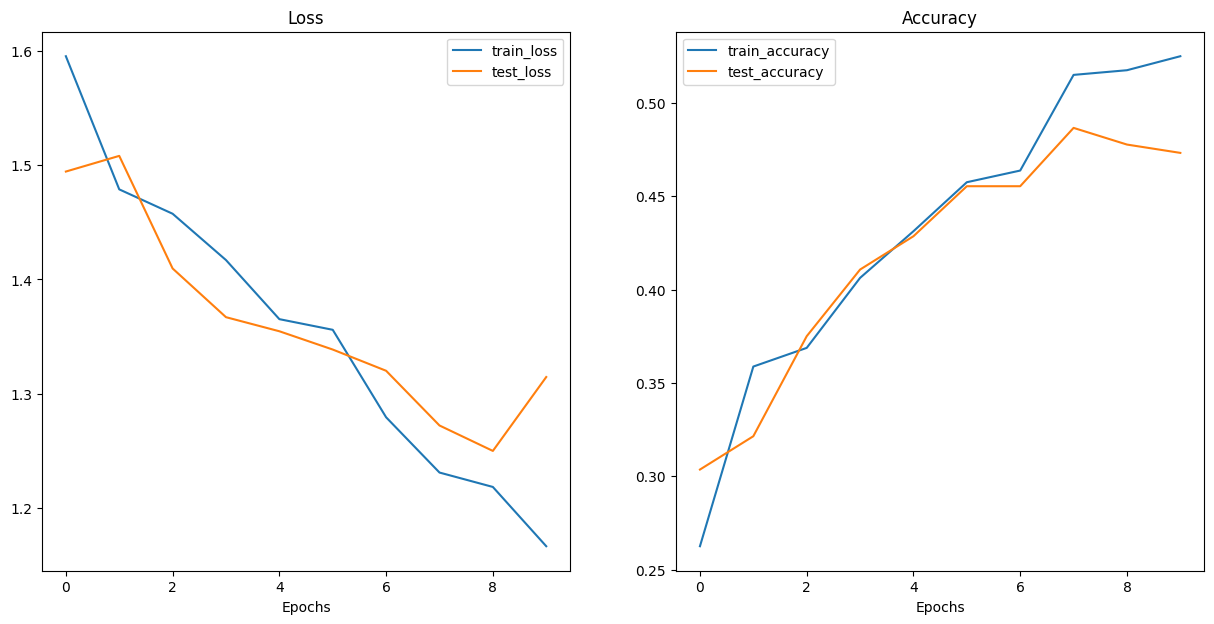

In [27]:
plot_loss_curves(model_0_results)

### 5.7 Visualize random predictions

In [28]:
test_data[0]

(tensor([[[0.7804, 0.7804, 0.7804,  ..., 0.0667, 0.0667, 0.0863],
          [0.7804, 0.7804, 0.7882,  ..., 0.0588, 0.0627, 0.0784],
          [0.7882, 0.7882, 0.7843,  ..., 0.0627, 0.0667, 0.0706],
          ...,
          [0.6235, 0.6471, 0.6392,  ..., 0.0588, 0.0667, 0.0549],
          [0.6314, 0.6353, 0.6275,  ..., 0.0353, 0.0549, 0.0745],
          [0.6392, 0.6431, 0.6275,  ..., 0.0353, 0.0471, 0.0706]],
 
         [[0.9059, 0.9098, 0.9137,  ..., 0.0824, 0.0784, 0.0863],
          [0.9137, 0.9137, 0.9216,  ..., 0.0784, 0.0745, 0.0824],
          [0.9216, 0.9216, 0.9176,  ..., 0.0824, 0.0745, 0.0706],
          ...,
          [0.6941, 0.7176, 0.7176,  ..., 0.0745, 0.0824, 0.0706],
          [0.7020, 0.7098, 0.7098,  ..., 0.0510, 0.0706, 0.0902],
          [0.7098, 0.7176, 0.7098,  ..., 0.0510, 0.0627, 0.0863]],
 
         [[0.9569, 0.9569, 0.9608,  ..., 0.0667, 0.0667, 0.0784],
          [0.9608, 0.9608, 0.9686,  ..., 0.0627, 0.0627, 0.0706],
          [0.9686, 0.9686, 0.9647,  ...,

In [34]:
# Create lists with random samples from test data
#random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9): # random 9 samples from test_data
  test_samples.append(sample)
  test_labels.append(label)

# Check the first sample shape
test_samples[0].shape

torch.Size([3, 224, 224])

In [35]:
# Functionize making predictions for images (non-batch)
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (unsqueeze to add batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [36]:
# Make predictions
pred_probs = make_predictions(model=model_0,
                              data=test_samples,
                              device=device)

pred_probs[0]

tensor([0.3713, 0.3143, 0.0376, 0.1476, 0.1291])

In [37]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([0, 0, 1, 4, 4, 1, 3, 4, 3])

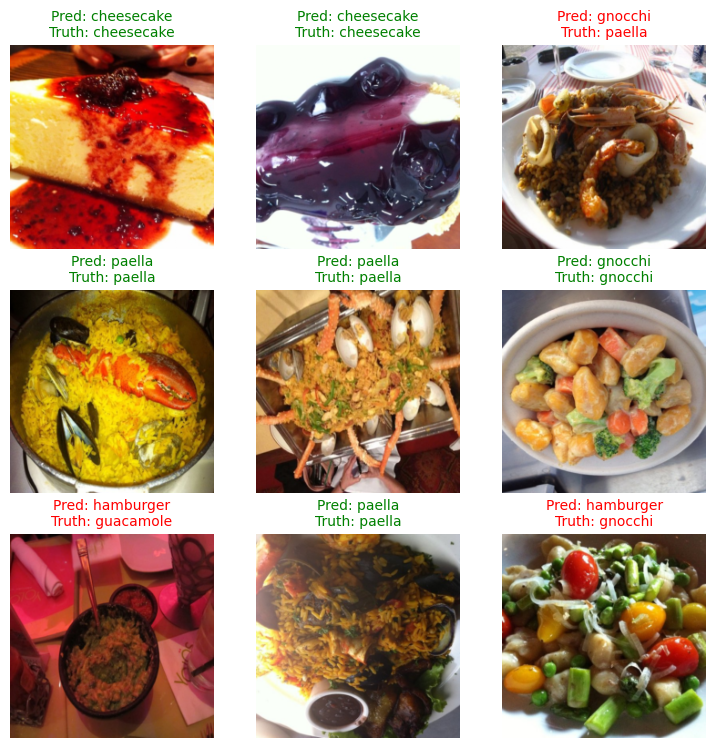

In [38]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1, 2, 0).squeeze())

  # Find the prediction
  pred_label = class_names[pred_classes[i]]

  # Get the truth label
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label}\nTruth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # green text if prediction same as truth
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

## 6. Make prediction on a custom image

In [50]:
# Download custom image
import requests

# Enter image url
IMAGE_URL = "https://na-talerzu.pl/wp-content/uploads/2022/08/Paella-z-krewetkami-i-chorizo-0849-2.jpg"
#IMAGE_URL = "https://cdn.galleries.smcloud.net/t/galleries/gf-orF8-m5r7-KWjU_domowy-hamburger-z-kurczakiem-pyszny-i-zdrowy-1920x1080-nocrop.jpg"


# Setup custom image path
custom_image_path = data_path / "test_image.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get(IMAGE_URL)
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

In [51]:
# Load the image
import torchvision
custom_image = torchvision.io.read_image(str(custom_image_path))
custom_image

tensor([[[ 87,  98, 104,  ...,  37,  36,  32],
         [ 85,  97, 103,  ...,  40,  40,  36],
         [ 80,  93, 102,  ...,  41,  39,  37],
         ...,
         [ 38,  42,  38,  ...,  17,  16,  15],
         [ 39,  38,  34,  ...,  17,  16,  15],
         [ 40,  36,  31,  ...,  16,  15,  14]],

        [[121, 131, 129,  ...,  65,  64,  60],
         [119, 130, 128,  ...,  68,  68,  64],
         [113, 125, 127,  ...,  69,  67,  65],
         ...,
         [ 73,  77,  70,  ...,  33,  32,  31],
         [ 74,  73,  66,  ...,  33,  32,  31],
         [ 75,  71,  63,  ...,  32,  31,  30]],

        [[130, 138, 133,  ...,  87,  86,  82],
         [129, 139, 133,  ...,  90,  90,  86],
         [128, 136, 134,  ...,  91,  89,  87],
         ...,
         [ 95,  99,  93,  ...,  46,  45,  44],
         [ 96,  95,  89,  ...,  48,  47,  46],
         [ 97,  93,  86,  ...,  47,  46,  45]]], dtype=torch.uint8)

In [52]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([transforms.Resize(size=(224, 224), antialias=True)])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 1440, 1920])
Transformed shape: torch.Size([3, 224, 224])


In [53]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: list[str] = None,
                        transform=None,
                        device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between [0, 1]
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch dimension)
    target_image = target_image.unsqueeze(0)

    # Make a prediciton on the image with an extra dimension
    target_image_pred = model(target_image.to(device))

  # Convert logits -> prediction probabilities
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange shape to be HWC
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label.cpu()} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

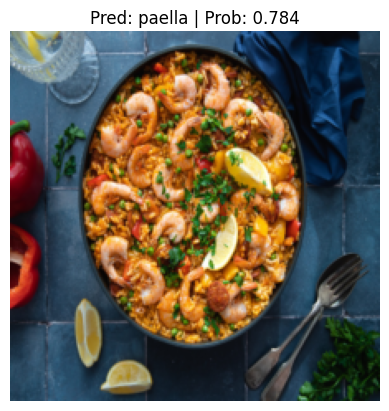

In [54]:
# Pred on our custom image
pred_and_plot_image(model=model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

## 7. Save the model and verify if loads correctly

In [58]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "TinyVGG_for_Food101_Extract.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to models/TinyVGG_for_Food101_Extract.pth


In [60]:
# Create a new instance and send to target device
loaded_model_0 = TinyVGG(input_shape=3,
                         hidden_units=20,
                         output_shape=len(train_data.classes)).to(device)

# Load in the save state_dict()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

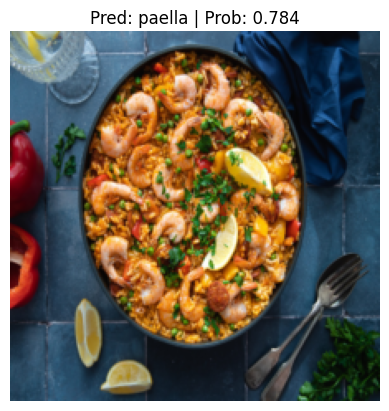

In [61]:
# Check prediction on the custom image
pred_and_plot_image(model=loaded_model_0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)